In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import association_rules, apriori
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [3]:
df = pd.read_json("/Users/federicoyoungmendiola/Downloads/renttherunway_final_data.json",lines=True)


In [4]:
df.head(5)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
fit               192544 non-null object
user_id           192544 non-null int64
bust size         174133 non-null object
item_id           192544 non-null int64
weight            162562 non-null object
rating            192462 non-null float64
rented for        192534 non-null object
review_text       192544 non-null object
body type         177907 non-null object
review_summary    192544 non-null object
category          192544 non-null object
height            191867 non-null object
size              192544 non-null int64
age               191584 non-null float64
review_date       192544 non-null object
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB


In [5]:
print('Qty of Transactions:\t', df.shape[0])
print('Qty of Features:\t', df.shape[1])


Qty of Transactions:	 192544
Qty of Features:	 15


In [6]:
df.user_id.value_counts()

691468    436
32925     292
362951    228
45337     140
833675    128
         ... 
561631      1
883170      1
881123      1
606693      1
112759      1
Name: user_id, Length: 105571, dtype: int64

## EDA

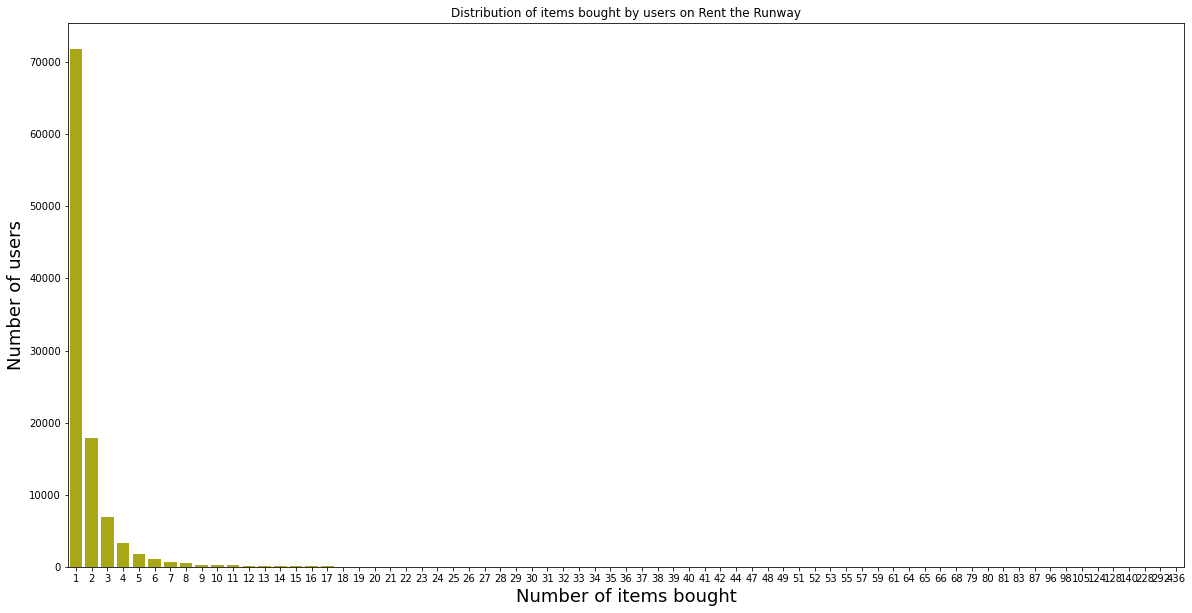

In [5]:
# Users who bought so many items
items_bought = []
total_users = []
for i in range(min(df.user_id.value_counts()), max(df.user_id.value_counts())+1):
    all_users = sum(df.user_id.value_counts() == i)
    if all_users != 0:
        total_users.append(all_users)
        items_bought.append(i)
plt.xlabel("Number of items bought", fontsize = 18)
plt.ylabel("Number of users", fontsize = 18)
plt.title("Distribution of items bought by users on Rent the Runway")
__ = sns.barplot(x=items_bought, y=total_users, color='y')
fig = plt.gcf()
fig.set_size_inches(20,10)


66% of the users bought only one item 

### Ratings distribution

Text(0.5, 1.0, "Distribution of 'Ratings'")

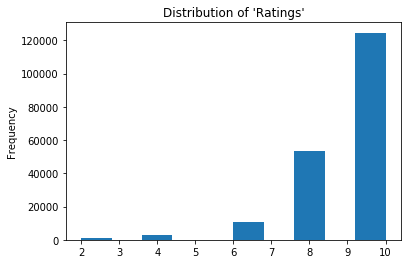

In [8]:
df.rating.plot.hist()
plt.title("Distribution of 'Ratings'")


As we could see in the histogram plot, our dataset seems to be desbalanced. Almost all ratings are 8 or 10.

### 'Rented for'

Text(0.5, 1.0, "Distribution of 'Rented for'")

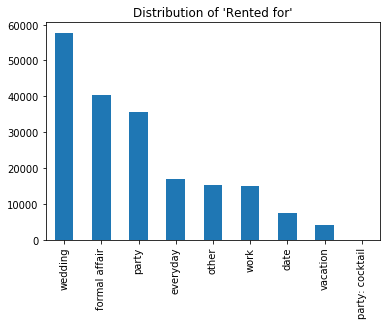

In [9]:
df["rented for"].value_counts().plot(kind='bar')
plt.title("Distribution of 'Rented for'")


In [10]:
df[df['rented for']== 'party: cocktail']

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
100942,fit,289468,34b,174258,114lbs,8.0,party: cocktail,"I actually thought both the 4 and 6 fit me, bu...",petite,Gorgeous and comfortable!,dress,"5' 2""",12,35.0,"November 9, 2011"


### 'Body type'

Text(0.5, 1.0, "Distribution of 'Body type'")

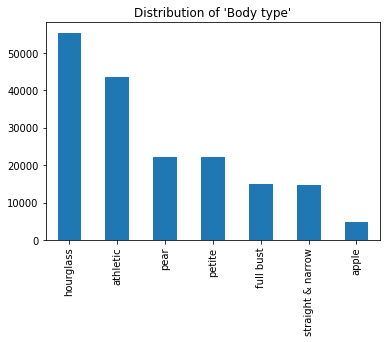

In [11]:
#Cantidad de ocaciones de compra
df["body type"].value_counts().plot(kind='bar')
plt.title("Distribution of 'Body type'")


### 'Category'

In [ ]:
highest_categories = df[df['category']]

In [23]:
df['category'].value_counts()

dress           92884
gown            44381
sheath          19316
shift            5365
jumpsuit         5184
                ...  
sweatershirt        4
sweatpants          2
overcoat            2
buttondown          1
crewneck            1
Name: category, Length: 68, dtype: int64

In [19]:
highest_categories = pd.DataFrame(df['category'].value_counts())
len(highest_categories[highest_categories.category <1000])

56

Text(0.5, 1.0, "Distribution of 'Category'")

<Figure size 1440x720 with 0 Axes>

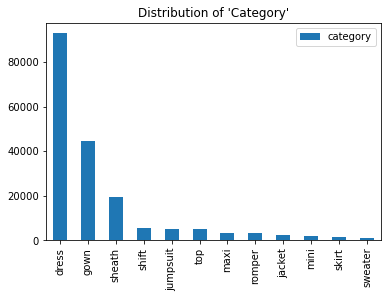

In [17]:
plt.figure(figsize=(20, 10))
highest_categories[highest_categories.category >1000].plot(kind='bar')
plt.title("Distribution of 'Category'")


In [13]:
count_category = df["category"].value_counts()
print('Qty of categories with less than 500 values:\t', len(count_category[count_category<500]))
print('Qty of transactions related to this categories:\t',sum(count_category[count_category<500]))
#DUDA: Preguntar si esta bien quitar estos 500 transacciones que tienen 52 categorias nuevas.

Qty of categories with less than 500 values:	 52
Qty of transactions related to this categories:	 3993


In [14]:
df["item_id"].value_counts()

126335     2241
174086     1724
123793     1714
132738     1582
145906     1478
           ... 
357517        1
2044810       1
2849197       1
2263613       1
1682009       1
Name: item_id, Length: 5850, dtype: int64

In [15]:
df_categorical = df.select_dtypes(include = ["object"])

In [16]:
df_categorical2 = df_categorical[["rented for","body type","category"]]
df_categorical2

,rented for,body type,category
0,vacation,hourglass,romper
1,other,straight & narrow,gown
2,party,NaN,sheath
3,formal affair,pear,dress
4,wedding,athletic,gown
...,...,...,...
192539,work,hourglass,jumpsuit
192540,work,petite,dress
192541,everyday,straight & narrow,dress
192542,wedding,pear,dress


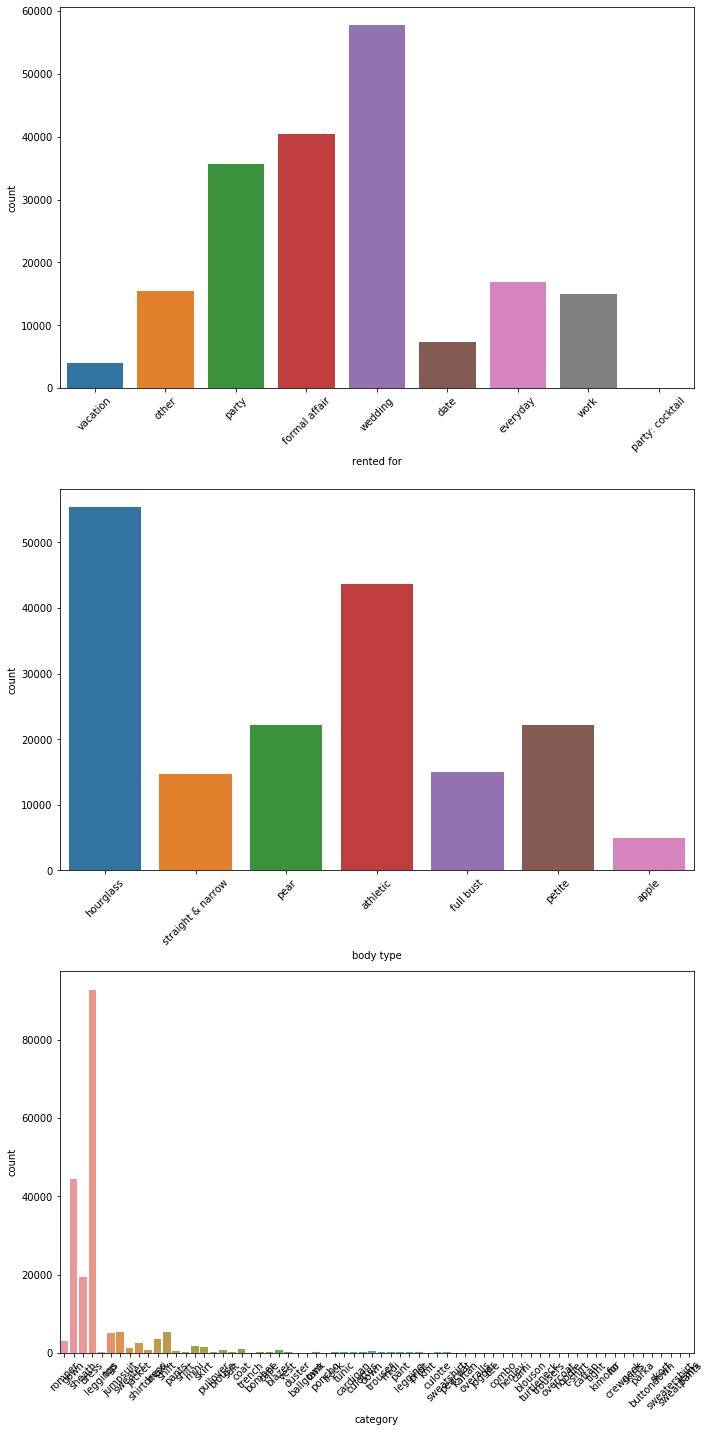

In [17]:
fig, axes = plt.subplots(round(len(df_categorical2.columns) ), 1, figsize=(10, 20))

for i, ax in enumerate(fig.axes):
    if i < len(df_categorical2.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation =45)
        sns.countplot(x=df_categorical2.columns[i], data=df_categorical2,ax=ax)

fig.tight_layout()

### Handling Missing values

In [18]:
## lets create a functions that can be used for summarize missing data
def percent_missing_data(df):
    missing_count = df.isna().sum().sort_values(ascending = False)
    missing_percent = 100 * df.isna().sum().sort_values(ascending = False) / len(df)
    missing_count = pd.DataFrame(missing_count[missing_count > 0])
    missing_percent = pd.DataFrame(missing_percent[missing_percent > 0])
    missing_table = pd.concat([missing_count,missing_percent], axis = 1)
    missing_table.columns = ["missing_count", "missing_percent"]
    
    return missing_table

            missing_count  missing_percent
weight              29982        15.571506
bust size           18411         9.561970
body type           14637         7.601899
age                   960         0.498587
height                677         0.351608
rating                 82         0.042588
rented for             10         0.005194


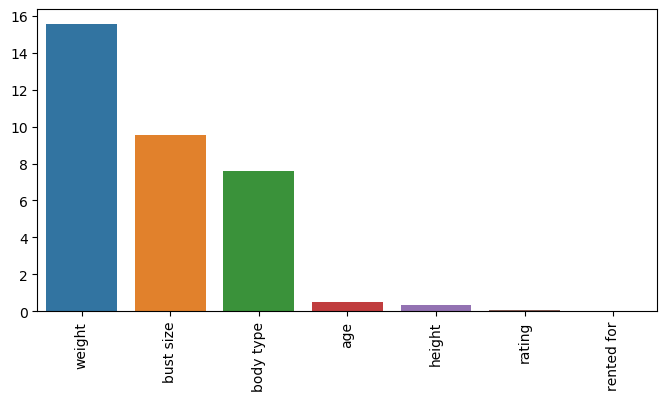

In [19]:
#Getting columns with missing values
print(percent_missing_data(df))

plt.figure(figsize = (8,4), dpi = 100)
sns.barplot(x = percent_missing_data(df).index, y = percent_missing_data(df).values[:,1])
plt.xticks(rotation = 90)
plt.show()

In [20]:
#Droping NULL values from Body type, rating and render for as we will use these features for the analysis
df_columns_complete = df.dropna(subset=["body type","rating","rented for"])
print(percent_missing_data(df_columns_complete))

           missing_count  missing_percent
weight             23995        13.494362
bust size          12315         6.925737
height               548         0.308185
age                  404         0.227202


# Train y Test

In [21]:
#Assign X as the original ratings dataframe and y as the user_id column of ratings.
X = df_columns_complete.copy()

In [22]:
#Quedarnos con los usuarios que tienen mas de una compra (sin cold start)
users_more_1 = (X['user_id'].value_counts()==1)
users_more_1 = np.array((users_more_1[users_more_1 == False]).index)

In [23]:
#Filtramos el df para dejarlo con los usuarios sin cold start
boolean_series = X["user_id"].isin(users_more_1)
X_sin_coldstart = X[boolean_series]
X_sin_coldstart.shape

(113079, 15)

In [24]:
#Split into training and test datasets, stratified along user_id
X_train, X_test = train_test_split(X_sin_coldstart,
                                   stratify= X_sin_coldstart["user_id"],
                                   test_size = 0.30, 
                                   random_state=48) 

In [25]:
#Filtramos los usuarios con una sola transaccion para agregarlos a train
boolean_series = ~X["user_id"].isin(users_more_1) #~ quiere decir is not in
X_con_coldstart = X[boolean_series]
X_con_coldstart.shape

(64736, 15)

In [26]:
#Le agregamos a X train los usuarios con cold start
X_train.append(X_con_coldstart)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
150264,fit,13906,34b,2616422,115lbs,10.0,everyday,its loose fitting in a good way,straight & narrow,"loved it, fun blouse, super pretty and easy to...",top,"5' 7""",8,32.0,"January 3, 2018"
185372,fit,18490,32c,152836,115lbs,8.0,date,This dress was amazing! It fit like a glove a...,petite,Love it!,mini,"5' 0""",4,37.0,"March 30, 2014"
11643,fit,476969,32b,176490,130lbs,10.0,wedding,I loved wearing this dress. It is really struc...,athletic,Love it.,dress,"5' 7""",8,34.0,"April 21, 2016"
45261,fit,542220,34c,1777332,138lbs,8.0,work,It's a little boxy and very warm as it is wool...,athletic,"Classy, conservative work dress.",dress,"5' 7""",12,32.0,"February 10, 2016"
116062,fit,334094,34a,1547971,130lbs,10.0,wedding,Rented this dress for a black-tie wedding and ...,straight & narrow,"Elegant, interesting, glamorous… can I keep it?",gown,"5' 6""",8,32.0,"March 25, 2016"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192528,small,597756,38dd,300980,220lbs,10.0,wedding,First time using RTR. I wasn't sure what to ex...,full bust,I felt fierce in this dress!,dress,"5' 4""",35,32.0,"November 12, 2017"
192532,small,838239,36c,863680,150lbs,10.0,wedding,Absolutely stunning dress. details and tulle m...,hourglass,"Made for a princess. Stunning, elegant, great ...",dress,"5' 0""",24,55.0,"July 25, 2017"
192536,large,442241,34d,166633,127lbs,8.0,wedding,Based on reviews I ordered a 4 and a 6. The 4 ...,full bust,"I received so many compliments on the dress, ...",mini,"5' 5""",8,33.0,"April 15, 2014"
192542,fit,961120,36c,126335,165lbs,10.0,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,"5' 6""",16,31.0,"November 25, 2015"


In [27]:
X_train.to_csv("X_train.csv",index=False)
X_test.to_csv("X_test.csv",index=False)